In [2]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [4]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [5]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/competitions/aptos2019-blindness-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sharmasanyam


Your Kaggle Key:

  ································


100%|██████████| 9.51G/9.51G [00:58<00:00, 174MB/s] 



Extracting archive ./aptos2019-blindness-detection/aptos2019-blindness-detection.zip to ./aptos2019-blindness-detection


In [6]:
path = "/kaggle/working/aptos2019-blindness-detection/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


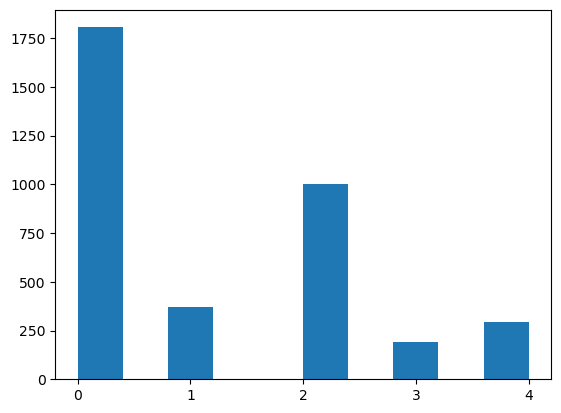

In [7]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [8]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


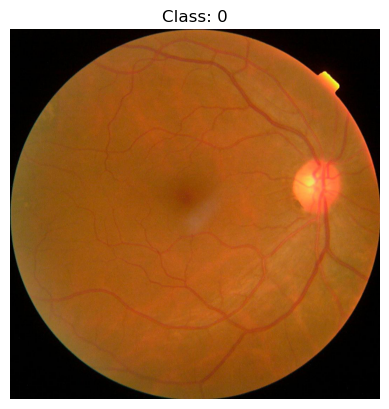

In [9]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

In [10]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [11]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [12]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

In [13]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet34 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(
                         nn.Linear(512,128),
                         nn.ReLU(inplace=True),
                         nn.Dropout(0.1),
                         nn.Linear(128,5),    
                    )

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [14]:
model = model.to(device) #Moves the model to the device.

In [15]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [16]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [17]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [18]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005) 
nb_epochs = 40
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/40
-------------------------------

Training Loss = 1.401061	Accuracy on Training set = 59.842520% [1976/3302]

Validation Loss = 1.286557	Accuracy on Validation set = 62.777778% [226/360]

Epoch 2/40
-------------------------------

Training Loss = 1.079799	Accuracy on Training set = 69.109631% [2282/3302]

Validation Loss = 1.093998	Accuracy on Validation set = 74.444444% [268/360]

Epoch 3/40
-------------------------------

Training Loss = 0.905190	Accuracy on Training set = 73.591763% [2430/3302]

Validation Loss = 0.992009	Accuracy on Validation set = 71.388889% [257/360]

Epoch 4/40
-------------------------------

Training Loss = 0.801187	Accuracy on Training set = 77.498486% [2559/3302]

Validation Loss = 0.936176	Accuracy on Validation set = 68.333333% [246/360]

Epoch 5/40
-------------------------------

Training Loss = 0.718431	Accuracy on Training set = 80.254391% [2650/3302]

Validation Loss = 1.238710	Accuracy on Validation set = 65.555556% [236/360]

Epoch 6/4

In [3]:
training_accuracy = [59.842520,
                    69.109631,
                    73.591763,
                    77.498486,
                    80.254391,
                    81.132647,
                    84.827377,
                    87.189582,
                    90.520896,
                    92.459116,
                    94.215627,
                    95.941853,
                    95.972138,
                    97.395518,
                    97.668080,
                    98.031496,
                    98.122350,
                    98.606905,
                    98.546336,
                    98.485766,
                    98.788613,
                    98.758328,
                    98.849182,
                    99.030890,
                    98.970321,
                    98.879467,
                    93.064809,
                    99.000606,
                    98.940036,
                    99.121744,
                    99.000606,
                    99.152029,
                    98.879467,
                    98.970321,
                    98.940036,
                    99.030890,
                    98.485766,
                    99.091460,
                    98.879467,
                    99.121744]
for i in range(40):
    training_accuracy[i] /= 100
print(training_accuracy)

[0.5984252, 0.6910963099999999, 0.73591763, 0.77498486, 0.80254391, 0.81132647, 0.84827377, 0.87189582, 0.90520896, 0.92459116, 0.94215627, 0.95941853, 0.95972138, 0.9739551799999999, 0.9766808, 0.9803149600000001, 0.9812235, 0.98606905, 0.98546336, 0.98485766, 0.98788613, 0.9875832800000001, 0.98849182, 0.9903089, 0.9897032099999999, 0.9887946700000001, 0.9306480899999999, 0.99000606, 0.9894003600000001, 0.9912174400000001, 0.99000606, 0.99152029, 0.9887946700000001, 0.9897032099999999, 0.9894003600000001, 0.9903089, 0.98485766, 0.9909146, 0.9887946700000001, 0.9912174400000001]


In [1]:
validation_accuracy = [62.777778,
                      74.444444,
                      71.388889,
                      68.333333,
                      65.555556,
                      81.111111,
                      73.055556,
                      75.833333,
                      79.444444,
                      79.166667,
                      78.888889,
                      77.500000,
                      75.000000,
                      75.833333,
                      79.166667,
                      78.333333,
                      79.444444,
                      78.055556,
                      76.111111,
                      81.388889,
                      78.611111,
                      78.888889,
                      80.555556,
                      78.611111,
                      80.833333,
                      67.222222,
                      78.333333,
                      82.222222,
                      84.222222,
                      86.222222,
                      85.555556,
                      87.578888,
                      78.055556,
                      82.222222,
                      79.166667,
                      75.833333,
                      81.388889,
                      72.777778,
                      80.277778,
                      78.888889]
for i in range(40):
    validation_accuracy[i] /= 100
print(validation_accuracy)

[0.62777778, 0.7444444400000001, 0.7138888900000001, 0.68333333, 0.6555555599999999, 0.8111111099999999, 0.73055556, 0.7583333299999999, 0.79444444, 0.79166667, 0.7888888900000001, 0.775, 0.75, 0.7583333299999999, 0.79166667, 0.7833333299999999, 0.79444444, 0.7805555599999999, 0.76111111, 0.8138888900000001, 0.7861111099999999, 0.7888888900000001, 0.80555556, 0.7861111099999999, 0.80833333, 0.67222222, 0.7833333299999999, 0.82222222, 0.84222222, 0.86222222, 0.85555556, 0.8757888800000001, 0.7805555599999999, 0.82222222, 0.79166667, 0.7583333299999999, 0.8138888900000001, 0.7277777799999999, 0.80277778, 0.7888888900000001]


In [2]:
training_loss = [1.4010614982018104,
 1.0797987540180867,
 0.9051901107797256,
 0.8011872115043494,
 0.7184309168503835,
 0.6654457885485429,
 0.5347569917257016,
 0.4523946260317014,
 0.3509340700335227,
 0.2850714585958765,
 0.21618864244709796,
 0.15417348353478771,
 0.16413170256866857,
 0.12132377005540408,
 0.1014929165920386,
 0.0936501758137288,
 0.08475658140825824,
 0.06957892487900189,
 0.06613247105493568,
 0.07318597037542182,
 0.05877649586182088,
 0.05289437877945602,
 0.04919507697923109,
 0.0436781948306956,
 0.043714661795932516,
 0.058807026800842814,
 0.22172135999426246,
 0.05440081360911091,
 0.047603702620388225,
 0.03957066738691468,
 0.039697819191272944,
 0.042373646467100255,
 0.045536712517227546,
 0.041625851910794154,
 0.0467024734579564,
 0.04347457142900497,
 0.05698455181957867,
 0.04159414381809676,
 0.041124026387338884,
 0.03359692407404789]

In [4]:
validation_loss = [1.2865566710631053,
 1.0939981043338776,
 0.9920088946819305,
 0.936175728837649,
 1.2387103339036305,
 0.9585545659065247,
 1.0737789422273636,
 1.096439316868782,
 1.2984283566474915,
 1.320573831597964,
 1.3227456162373226,
 1.68094335993131,
 1.9688145915667217,
 1.4407115479310353,
 1.7029301524162292,
 1.647461473941803,
 1.6627733608086903,
 1.9050438404083252,
 2.337301512559255,
 1.7959218273560207,
 1.5614837110042572,
 1.8750125517447789,
 1.8477609306573868,
 2.0125748217105865,
 1.9511980613072712,
 1.4015759080648422,
 1.504172792037328,
 1.8693197170893352,
 1.7881563206513722,
 1.9746513962745667,
 1.9145345588525136,
 2.4416252275307975,
 1.9222965737183888,
 2.1744224031766257,
 1.8821896811326344,
 2.1837911705176034,
 2.0072962095340094,
 1.9298625215888023,
 2.2880168656508126,
 2.0305976470311484]

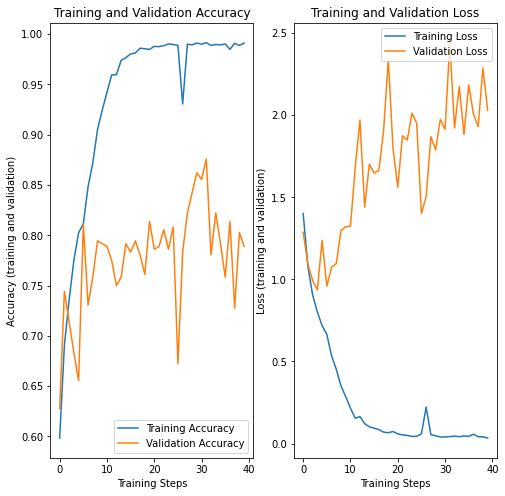

In [5]:
import matplotlib.pyplot as plt
acc = training_accuracy
val_acc = validation_accuracy

loss = training_loss
val_loss = validation_loss
EPOCHS=40

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()